# Genetic Algorithms and Evolutionary Computing

>This document serves a draft for the [UCGIS Book of Knowledge](https://gistbok.ucgis.org) piece with the same title. It contains detailed code and more experiments. All the code and this file are available at https://github.com/ncxiao/genetic-algorithms.

Genetic algorithms are a family of search methods that can be used to solve different optimization problems. Solving an optimization problem may require excessive amount of time and aside from exact methods that can return optimal solutions but may be infeasible due to their computational intensive, a wide range of search methods, called heuristics, have been developed. A classical solution method is hill climbing, in which we start from a random initial solution and keep changing it toward a direction until no improvement can be found. Almost all heuristics face a challenge: how to escape local optimal solutions during the search process in order to approach the global optimal solution. Genetic algorithms have their own strategies to achieve this.

A GA is formed by a group of individual solutions that together are called a population. Individuals in the population are randomly initialized. Each individual solution is evaluated by computing its fitness value, which is often based on the objective function. Among all individuals, those with higher fitness values are more desired and therefore are more likely to be used to create the next generation of population. The individuals in the population repeatedly go through a reproduction process in which individuals with high fitness values are likely to be used to create their offspring. The reproduction process goes a number of iterations as defined by the programmer. During each iteration, a selection operation is used to choose individuals from the current population, where individuals with high fitness values have a high likelihood to be selected. A crossover operation is used to recombine the values in the selected parent solutions in order to create their offspring. A small number of the offspring will also go through a mutation operation that will randomly change the values in the solution. New individuals generated in this way are then used to replace the current population and the process continues until the maximum number of generation is reached. The following figure illustrates the iterative process of a GA.

![](ea_proc.png)

## Elements of Genetic Algorithms

To demonstrate how a GA works, we use a specific optimization problem defined below and design a GA to solve it. We implement the GA using the Python programming language. 

$$\max x_1^2 - x_2 - x_3 + 1$$

where $x_1$, $x_2$, and $x_3$ are integers in the range of 0 and 7. This is a simple problem where the optimal solution is $x_1 = 7, x_2 = 0, x_3 = 0$. 

### Encoding and decoding

To represent a solution to this problem, we use a binary string of 3 digits to encode each of the variables. For example, a binary string of `010` represents a value of 10. Together, a binary string of 9 digits can be used to represent the three variables. For example, a string of `110010001` represents three values 6, 2, and 1 for variables $x_1$, $x_2$, and $x_3$, respectively. 

With this encoding strategy, there is a need to decode the binary string when we calculate the objective function value for a given encoded solution. We write the following Python function to decode a 9-digit binary string. The function returns a tuple of three values.

In [1]:
def decode(s):
    def _decode(s):
        num = 0
        n = len(s)
        for i in range(n):
            c = s[n-i-1]
            num += int(c) * 2 ** i
        return num
    return _decode(s[:3]), _decode(s[3:6]), _decode(s[6:])

In [2]:
decode('110010001')

(6, 2, 1)

### Generating random solutions

With the encoding strategy, we can design a method to generating random solution to the problem. For the specific problem used here, an initial solution can be created by randomly assigning 0 or 1 to each of the 9 digits in the binary string. To do so, we first introduce a useful function called `flip` to mimic the process of flipping a coin with a given probability. The function returns a True or False value. When the input probability is high, it will have a high likelihood to return a True value.

In [3]:
from random import random, randint, sample, uniform

def flip(prob):
    if random() < prob:
        return True
    return False

For example, the following code tests how many True values will be returned when the probability is set to 0.9. The count should be close to 9.

In [6]:
vals = [flip(0.9) for _ in range(10)]
print(vals, sum(vals))

[True, True, True, True, True, True, False, True, True, True] 9


And the following code will generate a string of binary string of 9 digits where each digit is randomly determined.

In [7]:
''.join(['1' if flip(0.5) else '0' for i in range(9)])

'000111111'

In [9]:
s = ''.join(['1' if flip(0.5) else '0' for i in range(9)])
print(s)
decode(s)

111001000


(7, 1, 0)

### Evaluation

There are two key issues in evaluating a given solution. First, the objective function value of that solution must be calculated, which can be done by implementing the objective function of the problem. The following `obj` function computes the objective function values given a tuple of three values:

In [10]:
def obj(x):
    return x[0] ** 2 - x[1] - x[2] + 1

It can be tested using our previous example of a binary string:

In [11]:
obj(decode('110010001'))

34

The objective function, however, are often indirectly used in a GA. Instead, GAs use a fitness value to indicate how an individual fits in the population in terms of how close it is to the optimal solution. A higher fitness value is always more desired than a lower one. Fitness values should also be non-negative. For a specific optimization problem, it is often the case when the objective function value may not be readily used as the fitness value. In our case, even though we maximize the objective function -- which means a higher objective function value is closer to the optimal than a lower one -- it does not guarantee non-negativity and therefore there is a need to convert an objective value to a fitness value.

The function `obj2fitness` does the conversion. It should be noted that converting objective function values to fitness values is highly problem specific and often requires that we know the objective function values of the entire population of solutions. For this reason, the `obj2fitness` function takes a list of objective function values as the input and returns a list of fitness values. In this particular implementation, the idea is to shift all objective function values linearly so that the lowest value will become non-negative. Also, we do not want the lowest value to be zero, because that will mean individuals with zero fitness will not have any chance to be selected later in the GA process. We use 10 percent of the range between the highest and lowest objective function value as the minimal fitness value. This is arbitrary, but effective in making it to work.

In [12]:
def obj2fitness(objs):
    low = min(objs)
    minimal = (max(objs) - low) * 0.1
    fitnesses = [val - low + minimal for val in objs]
    return fitnesses

### Initialization

Now, we write code to set the initial population of the GA. The `initialization` function generates an initial population of solutions and evaluates the solutions. It returns three lists: randomly generated solutions to the problem, the objective function values of the random solutions, and the fitness values, respectively. Here, each (initial) solution is a string of 0’s and 1’s, where each digit is randomly decided using the flip function with a probability of 0.5 (Lines 4 and 5).

In [13]:
def initialization(popsize):
    population = []
    for i in range(popsize):
        sol = ''.join(['1' if flip(0.5) else '0' 
                       for i in range(9)])
        population.append(sol)
    objs = [obj(decode(s)) for s in population]
    fitnesses = obj2fitness(objs)
    return population, objs, fitnesses

The following is an example of generating an initial population of 2 random solutions:

In [15]:
initialization(2)

(['110010101', '010010001'], [30, 2], [30.8, 2.8000000000000003])

### Selection

Given a population of individual solutions, a selection operator can be defined so that the individuals with high fitness values will have a high chance to be selected. The following function uses a roulette mechanism where the probability of each individual being selected is proportional to its fitness value. 

In [16]:
def select(fitnesses):
    total = sum(fitnesses)
    r = uniform(0, total)
    acc = 0
    for i in range(len(fitnesses)):
        acc += fitnesses[i]
        if acc >= r:
            return i

The `select` function is tested below on an initial population of 10 individuals.

In [20]:
population, objs, fitnesses = initialization(10)
i, j = select(fitnesses), select(fitnesses)
print(objs)
print(fitnesses)
print(objs[i], objs[j])

[40, -3, 0, 19, 19, -5, -5, 4, 12, 19]
[49.5, 6.5, 9.5, 28.5, 28.5, 4.5, 4.5, 13.5, 21.5, 28.5]
40 4


### Crossover 

A commonly used method to recombine two solutions is called single point crossover. In this method, we find a random position in the binary string and the digits to the right of this point in the two parent solutions are swapped. For example, if we have the following two parent solutions and use the position after the fourth digit as the point to swap:

```
1100 00110
1110 11111
```

we will create the following two child solutions:

```
1100 11111
1110 00110
```

The following `crossover` function takes two parent solutions (`p1` and `p2`) and a crossover probability. The probability determines the chance that the crossover operation will be carried out. 

In [21]:
def crossover(p1, p2, prob):
    if not flip(prob):
        return [p1, p2], 0
    x = randint(0, len(p1)-1)
    c1 = p1[:x] + p2[x:]
    c2 = p2[:x] + p1[x:]
    return [c1, c2], x

We test the effect of crossover using the two solutions selected from the initial solutions generated from the above code. As the result shows, it is clear that after the use of crossover a better solution is emerged.

In [26]:
parent1, parent2 = population[select(fitnesses)], population[select(fitnesses)]
obj1, obj2 = obj(decode(parent1)), obj(decode(parent2))
[child1, child2], x = crossover(parent1, parent2, 1)
obj1c, obj2c = obj(decode(child1)), obj(decode(child2))
print('Parents    Obj     Children   Obj')
print(parent1[:x], parent1[x:], obj1, ' -> ', child1[:x], child1[x:], obj1c)
print(parent2[:x], parent2[x:], obj2, ' -> ', child2[:x], child2[x:], obj2c)

Parents    Obj     Children   Obj
10111 1000 19  ->  10111 0100 16
11111 0100 40  ->  11111 1000 43


### Mutation 

The mutation operation serves a specific purpose by bringing new information into the population. This can be simply done by flipping the digits from 0 to 1, or vice versa, in each solution. We typically do not want to flip every digit in a solution, which may drastically disturb the solutions in the population. We use a probability to control whether a digit is to be mutated. Later in this document we will see how such a probability affects the overall performance of the GA.

In [27]:
def mutation(s, prob):
    _mutate = lambda i: '1' if i=='0' else '0'
    mutated = ''
    for c in s:
        if flip(prob):
            mutated += _mutate(c)
        else:
            mutated += c
    return mutated

### Elitism

We write the following function called `generation` to go through the main loop of reproduction in a GA procedure.

In [28]:
def generation(population, objs, fitnesses, pcrossover, pmutation, elitism=True):
    oldbest = max(objs)
    ibest = objs.index(oldbest)
    newpop = []
    while len(newpop) < len(population):
        p1 = population[select(fitnesses)]
        p2 = population[select(fitnesses)]
        offspring = crossover(p1, p2, pcrossover)[0]
        for s in offspring:
            c = mutation(s, pmutation)
            if len(newpop) < len(population):
                newpop.append(c)
            else:
                break
    newobjs = [obj(decode(s)) for s in newpop]
    newfitnesses = obj2fitness(newobjs)
    return newpop, newobjs, newfitnesses

The following is our first GA, which uses a population size of 10. it runs for 10 generations, using a crossover probability of 0.9 and mutation 0.1.

In [29]:
population, objs, fitnesses = initialization(10)
for i in range(10):
    population, objs, fitnesses = generation(population, objs, fitnesses, 0.9, 0.1)
print(max(objs))

48


However, the GA as is may lack the performance in finding the optimal solution to the problem. The following is a test to illustrate this problem. We note the parameters used here (population size, crossover probability, and mutation probability) are effective and a more detailed discussion about the impacts of these parameters is included later in this document.

In [33]:
all_result = []
for _ in range(10):
    population, objs, fitnesses = initialization(10)
    for i in range(10):
        population, objs, fitnesses = generation(population, objs, fitnesses, 0.9, 0.1)
    all_result.append(max(objs))

print(all_result)

[48, 47, 42, 48, 49, 43, 44, 47, 45, 50]


As shown in the above example, we run the GA 10 times and, in this particular example, it has a relatively poor performance as it does not frequently find the optimal solution. Such a problem is common in GAs: good solutions found in early stages of the GA generations tend to be lost in the crossover and mutation process. A simple approach to addressing this issue is elitism: we make sure the best solution found so far by the GA is kept in the population. The following is a revised version of function `generation` where the elitism mechanism is implemented.

In [34]:
def generation(population, objs, fitnesses, 
               pcrossover, pmutation, elitism=True):
    oldbest = max(objs)
    ibest = objs.index(oldbest)
    newpop = []
    while len(newpop) < len(population):
        p1 = population[select(fitnesses)]
        p2 = population[select(fitnesses)]
        offspring = crossover(p1, p2, pcrossover)[0]
        for s in offspring:
            c = mutation(s, pmutation)
            if len(newpop) < len(population):
                newpop.append(c)
            else:
                break
    newobjs = [obj(decode(s)) for s in newpop]
    if elitism:
        newbest = max(newobjs)
        inewworst = newobjs.index(min(newobjs))
        if oldbest > newbest: # oldbest is better
            newpop[inewworst] = population[ibest]
            newobjs[inewworst] = oldbest
    population = newpop
    objs = newobjs
    newfitnesses = obj2fitness(newobjs)
    return newpop, newobjs, newfitnesses


A quick test below will reveal that the use of elitism not only enables the GA to find more optimal solutions in multiple runs, it also improves the overall quality of solutions even when the optimum is not found.

In [35]:
all_result = []
for _ in range(10):
    population, objs, fitnesses = initialization(20)
    for i in range(10):
        population, objs, fitnesses = generation(population, objs, fitnesses, 0.9, 0.1)
    all_result.append(max(objs))

print(all_result)

[50, 50, 50, 50, 50, 50, 50, 50, 49, 50]


### GA and its parameters

Now we wrap up the code using a class to set all the parameters needed to run the GA and then define a specific function called `GA`. The `GA` function returns the best and average objective function value, along with the last population evolved by the algorithm.

In [36]:
class Parameters:
    def __init__(self, popsize, numgen, pcrossover, pmutation, elitism):
        self.popsize = popsize
        self.numgen = numgen
        self.pcrossover = pcrossover
        self.pmutation = pmutation
        self.elitism = elitism
        
def GA(param):
    population, objs, fitnesses = initialization(param.popsize)
    for i in range(param.numgen):
        population, objs, fitnesses = generation(
            population, objs, fitnesses, 
            param.pcrossover, param.pmutation, param.elitism)
    return max(objs), sum(objs)/param.popsize, population

This allows us to set and test the parameters.

In [37]:
param = Parameters(
    popsize = 10,
    numgen = 10,
    pcrossover = 0.8,
    pmutation = 0.1,
    elitism = True)

result = GA(param)
print(result[:2])
for s in result[2]:
    print(s)

(47, 29.9)
111000011
111000110
011001010
111011110
111000111
110000111
101100111
100001010
111010010
100100001


### GA convergence

The previous example shows that running a GA through multiple generation will lead to the optimal (or near-optimal) solution. Now we provide an empirical analysis of how the GA population evolves toward to the optimal as a whole. Here we run the GA 10 times, and each time we use a population size of 20, crossover probability of 0.9, and mutation probability of 0.1. We plot the best, worst, and average objective function values in the population in each generation. The plot clearly shows the best solution found in each generation all converge to the optimal solution (50) and average objective function values also show a clear trend of improving throughout the generations. The worst solutions in the population show a strong fluctuation, which is expected by design of the mutation operation. 


In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

In [39]:
reports = []
for _ in range(10):
    population, objs, fitnesses = initialization(20)
    reportx = []
    for i in range(20):
        population, objs, fitnesses = generation(population, objs, fitnesses, 0.9, 0.1)
        reportx.append([max(objs), min(objs), sum(objs)/len(population)])
    reports.append(reportx)

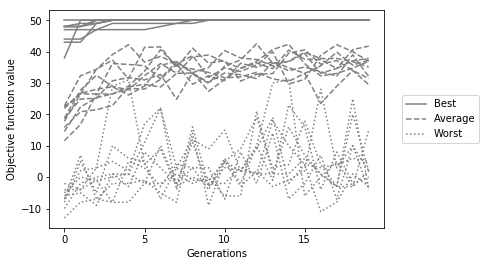

In [40]:
for report in reports[:-2]:
    plt.plot([r[0] for r in report], linestyle='-', color='grey')
    plt.plot([r[2] for r in report], linestyle='--', color='grey')
    plt.plot([r[1] for r in report], linestyle=':', color='grey')

report = reports[-1]
plt.plot([r[0] for r in report], linestyle='-', color='grey', label='Best')
plt.plot([r[2] for r in report], linestyle='--', color='grey', label='Average')
plt.plot([r[1] for r in report], linestyle=':', color='grey', label='Worst')

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Generations')
plt.ylabel('Objective function value')
plt.show()
# plt.savefig('ga_result_convergence.eps', format='eps', dpi=300, bbox_inches='tight')


## Performance of Genetic Algorithms

A GA requires a number of parameters to run and it is important to understand the impacts of those parameters on the performance of the GA. In our case, we must consider the values of the population size, number of generations, probabilities of crossover and mutation, and whether elitism is used. More specifically, we experiment the impacts of these parameters using different combinations of these parameters and examine how each parameter affects the ability of the GA in finding the optimal solution. 

Parameter             | Values
---------------------:|:--------------------
Population size       | 2, 4, 6, 8, 10, 12, 14, 16, 18, 20
Number of generations | 5, 10, 15, 20, 25, 30
Crossover probability | 0, 0.1, 0.3, 0.5, 0.7, 0.9
Mutation probability  | 0, 0.1, 0.3, 0.5, 0.7, 0.9
Elitism               | True, False

The following is the code that tests values.

```python
def run_many_GAs(n, param):
    all_best = []
    for i in range(n):
        res = GA(param)
        all_best.append(res[0])
    all_best.sort()
    return(all_best[n//2], all_best[0]) # return median and worst


def test():
    psizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    nruns = [5, 10, 15, 20, 25, 30]
    pcross = [0.1, 0.3, 0.5, 0.7, 0.9]
    pmutate = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
    elitisms = [True, False]

    for n in psizes:
        for nr in nruns:
            for pc in pcross:
                for pm in pmutate:
                    for e in elitisms:
                        paramx = Parameters(n, nr, pc, pm, e)
                        res = run_many_GAs(10, paramx)
                        print(n, nr, pc, pm, e, res[0], res[1])
```


For each combination of the parameter values, the GA is run 10 times and we report the best solution found in each run. The following figure shows the results of the experiments. Among the 10 runs, the median solutions are plotted in the left figure and worst solutions in the right.

<table>
    <tr>
        <td><img src="ga_results_1_median.png" width=400/></td>
        <td><img src="ga_results_1_worst.png" width=400/></td>
    </tr>
    <tr>
        <td style="text-align:center">Median</td>
        <td style="text-align:center">Worst</td>
    </tr>
</table>

A few general but critical observations can be made based on the test results. It is important to note that the term performance is specifically used here to indicate the ability of the GA finding the optimal solution to the problem.

- GA performance increases with population size and the number of generations.
- GA performance increases with crossover probability.
- The benefit of population size and number of generations decreases when these parameters reach a certain level. The same trend can also be found for crossover probability.
- GA performance increases when mutation is used. However, increasing mutation probability may not necessarily increase the performance. It is more common that a high mutation will lead to low performance.

## Genetic Algorithms for Spatial Optimization Problems

So far we have discussed GAs in their original form: the use of binary encoding, along with the crossover and mutation operations designed using such encoding. While binary encoding is effective, there are other types of optimization problems where different encoding strategies have become more effective. For many spatial optimization problems, for example, the goal is find a discrete set of spatial units. 

We use the p-median problem to demonstrate some special considerations of using GA for spatial optimization problems. The goal of solving a p-median problem is to locate p facilities on a network of n nodes so that the total distance from each node to its nearest facility is minimized. While there are infinite possibilities for the facilities to be located on the network, it is proved that at least one optimal solution exists when the facilities are located on the network nodes. This makes it possible to encode a p-median problem using p integers.

To formulate a p-median problem, we need a few special inputs, including the distance matrix between each pair of nodes, the number of nodes on the network, and the number of facilities to be selected. We use a hypothetical network from the literature (Xiao 2016) where these three inputs are given in the following three Python variables, respectively. This problem has a known optimal solution with a total distance of 40.

In [41]:
n = 8

distmatrix = [
    [0, 3, 13, 5, 12, 16, 17, 20],
    [3, 0, 10, 8, 9, 13, 14, 23],
    [13, 10, 0, 8, 9, 3, 14, 15],
    [5, 8, 8, 0, 17, 11, 22, 15],
    [12, 9, 9, 17, 0, 6, 5, 16],
    [16, 13, 3, 11, 6, 0, 11, 12],
    [17, 14, 14, 22, 5, 11, 0, 11],
    [20, 23, 15, 15, 16, 12, 11, 0]]

p = 2

The GA for the p-median problem will follow the similar structure of the Python code presented in the previous section. However, the specific implementation of some functions is different because of the problem setting is different.

A solution to the problem is encoded as a list of `p` integers, each representing the index number of the node being selected. The objective function value of a solution can therefore be calculated using the following function, which sums up the distance from each node to its nearest node in the solution. 

In [42]:
def obj(s):
    n = len(distmatrix)
    d_total = 0
    for i in range(n):
        d_min = float('inf')
        for j in s:
            if distmatrix[i][j] < d_min:
                d_min = distmatrix[i][j]
        d_total += d_min
    return d_total

With the `obj` function, we can then write the functions to compute the fitness values for a population of solutions. Here we simply use the reciprocal of the objective function value as the fitness value.

In [43]:
def obj2fitness(objs):
    fitnesses = [1/val for val in objs]
    return fitnesses

To initialize a solution to the problem, we randomly pick two nodes from the network.

In [44]:
def initialization(popsize, n, p):
    population = []
    for i in range(popsize):
        sol = sample(range(n), p)
        population.append(sol)
    objs = [obj(s) for s in population]
    fitnesses = obj2fitness(objs)
    return population, objs, fitnesses

The crossover operation is quite different from a typical GA using a binary encoding. We follow the algorithm designed by Alp et al. (2003). This method first combine all the unique integers from the two parent solutions. This may lead to an infeasible solution because, unless the two parent solutions are identical, the combined list will have more than `p` integers. The method continuously remove the values from the combined list until there are exactly `p` different integers in the list. Every time we take a greedy approach to choose which node to be removed from the list: we choose to remove the node that causes the least increase in total distance.

In [45]:
def crossover(s1, s2, prob):
    if not flip(prob):
        return s1
    p = len(s1)
    child = list(set(s1 + s2))
    while len(child) > p:
        d = float('inf')
        to_remove = -1
        for i in child:
            c1 = [j for j in child if j != i]
            d1 = obj(c1)
            if d1 < d:
                d = d1
                to_remove = i
        child = [j for j in child if j != to_remove]
    return child

The mutation operation serves the same purpose as with the previous example using binary string: we hope to bring new information into the population in order to explore different combinations of the nodes. However, we will need to make sure the solution is still valid after mutation. The function implemented below assigns a new value to a node only if the new value does not exists in the solution.

In [46]:
def mutation(s, prob):
    for i in range(len(s)):
        if not flip(prob):
            continue
        while True:
            j = randint(0, n-1)
            if not j in s: 
                s[i] = j
                break
    return s

The selection operation will be exactly the same as we have seen before. It is a roulette selection process based on the fitness values of the solutions in the population.

In [47]:
def select(fitnesses):
    total = sum(fitnesses)
    r = uniform(0, total)
    acc = 0
    for i in range(len(fitnesses)):
        acc += fitnesses[i]
        if acc >= r:
            return i

The `generation` function is largely similar to the previous example, except this time we minimize the objective function and therefore the elitism is implemented so that the solution with the minimal objective function value is kept to replace the one with the highest objective value.


In [48]:
def generation(pop, objs, fitnesses, pcrossover, pmutation, elitism=True):
    oldbest = min(objs)
    ibest = objs.index(oldbest)
    newpop = []
    for i in range(len(pop)):
        p1 = pop[select(fitnesses)]
        p2 = pop[select(fitnesses)]
        child1 = crossover(p1, p2, pcrossover)
        child1 = mutation(child1, pmutation)
        newpop.append(child1)
    newobjs = [obj(c) for c in newpop]
    if elitism:
        newbest = min(newobjs)
        iworst = newobjs.index(max(newobjs))
        if oldbest < newbest: # old best is better
            newpop[iworst] = pop[ibest]
            newobjs[iworst] = oldbest
    newfitnesses = obj2fitness(newobjs)
    return newpop, newobjs, newfitnesses

The function `GA` uses all the code implemented above, and we also use the same class of `Parameters` to organize the parameters used in the GA.

In [49]:
class Parameters:
    def __init__(self, popsize, numgen, pcrossover, pmutation, elitism):
        self.popsize = popsize
        self.numgen = numgen
        self.pcrossover = pcrossover
        self.pmutation = pmutation
        self.elitism = elitism

def GA(param):
    population, objs, fitnesses = initialization(
        param.popsize, n, p)
    for i in range(param.numgen):
        population, objs, fitnesses = generation(
            population, objs, fitnesses, 
            param.pcrossover, param.pmutation, param.elitism)
    return min(objs), sum(objs)/param.popsize, population

The following code tests how many times the optimal solution is found after running the GA 100 times.

In [52]:
param = Parameters(
    popsize = 4,
    numgen = 10,
    pcrossover = 0.9,
    pmutation = 0.8,
    elitism = True)

res = [GA(param)[0] for _ in range(100)]
print(sum([1 if r==40 else 0 for r in res]))

83


For the $p$-median problem, parameters such as number of generations and population size have similar impacts on the performance. Elitism is also effective. However, the above test uses a relatively high mutation probability of 0.8, and the result is somewhat unexpected based on what we have learned from the previous example using the binary string for a simple numerical problem---with such a high mutation rate we would expect a low performance but the GA finds the optimal solution 84 out of 100 times. We need to further examine the impact of mutation probability on GA performance.  More specifically, we test different combinations of mutation and crossover probabilities as listed in the following Table. For each combination of these two parameters, we run the GA 1000 times and see how many times the optimal solution (with a total distance of 40) is found. We use the fixed size of population (4) and number of generations (10) for the experiments. 

Parameter             | Values
---------------------:|:--------------------
Crossover probability | 0, 0.1, 0.3, 0.5, 0.7, 0.9
Mutation probability  | 0, 0.1, 0.3, 0.5, 0.7, 0.9


The testing result is shown in the following figure, where the numbers on each line indicate the mutation probability. It is clear from this experiment that mutation plays a crucial and different role here. Higher mutation probabilities appear to alway outperform lower ones. This is reasonable given the relatively small population size---it is unlikely that 4 solutions can explore all the nodes. Without crossover, the GA can only find the optimal solution by chance, and the chance appears to increase with mutation probability. 


In [54]:
def run_many_GAs(n, param):
    all_best = []
    for i in range(n):
        # res = GA(popsize, numgeneration, pcrossover, pmutation, elitism)
        res = GA(param)
        all_best.append(res[0])
    return sum([1 if res==40 else 0 for res in all_best])

pcross = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
pmutate = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
results = []
for pc in pcross:
    for pm in pmutate:
        paramx = Parameters(4, 10, pc, pm, True)
        res = run_many_GAs(1000, paramx)
        results.append([pc, pm, res])

We can plot the results using the following code.

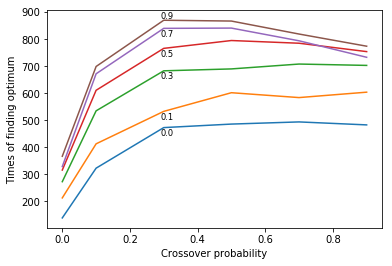

In [62]:
X = [] # pcross
Y = [] # pmutate
Z = [] # hits
for v in results:
    x = float(v[0])
    if not x in X:
        X.append(x)
    y = float(v[1])
    if not y in Y:
        Y.append(y)
    Z.append([float(v[0]), float(v[1]), float(v[2])])

Z1 = {}

for y in Y:
    Z1[y] = [z[2] for z in Z if z[0] == y]

for y in Y:
    plt.plot(X, Z1[y], label='{}'.format(y))
    if y < 0.9:
        plt.text(X[2]-0.01, Z1[y][2]-30, str(y), fontsize='small')
    else:
        plt.text(X[2]-0.01, Z1[y][2]+5, str(y), fontsize='small')

plt.xlabel('Crossover probability')
plt.ylabel('Times of finding optimum')
# plt.savefig('ga_results_pmed.eps', format='eps', dpi=300)  # plt.show()
plt.show()


## Discussion

Genetic algorithms belong to a general field of evolutionary computation inspired by evolutionary processes that can be observed in natural and biological systems. The selection operation in a GA plays a critical role in the search process, echoing the Darwinian principle of survival of the fittest. In addition to GAs, there are other types of search algorithms that apply the similar logic but are designed using different strategies of encoding and reproduction. For example, an evolutionary strategy (ES) uses real values instead of a binary strings. An ES contains only 1 parent solution and various mutation methods are used to create a number of mutants that will compete with and replace the parent. Genetic programming aims to evolve computer programs (instead of numerical optimization problems) that are represented as trees. 


## References 

Alp, O., Z. Drezner, and E. Erkut (2003). An efficient genetic algorithm for the p-median problem. Annals of Operations Research 122, 21–42.

Back, T., D. B. Fogel, and Z. Michalewicz (Eds.) (1997). Handbook of Evolutionary Computation, New York. Oxford University Press/IOP.

Daskin, M. S. (1995). Network and Discrete Location: Models, Algorithms, and Applications. New York: John Wiley & Sons.

Goldberg, D. E. (1989). Genetic Algorithms in Search, Optimization and Machine Learning. Reading, MA: Addison-Wesley.

Koza, J. R. (1992). Genetic Programming: On the Programming of Computers by Means of Natural Selection. Cambridge, MA: The MIT Press.

Rechenberg, I. (1965). Cybernetic Solution Path of an Experimental Problem. Farnborough, Hants, U.K.: Royal Aircraft Establishment, Library Translation No. 1122.

Xiao, N. (2016). GIS Algorithms. London: SAGE Publications.

Xiao, N. and A. T. Murray (2019). Spatial optimization for land acquisition problems: A review of models, solution methods, and GIS support. Transactions in GIS, DOI:10.1111/tgis.12545.

## Additional Sources

https://www.mathworks.com/help/gads/genetic-algorithm.html

https://github.com/deap/deap


Ningchuan Xiao (ncxiao@gmail.com)